In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *

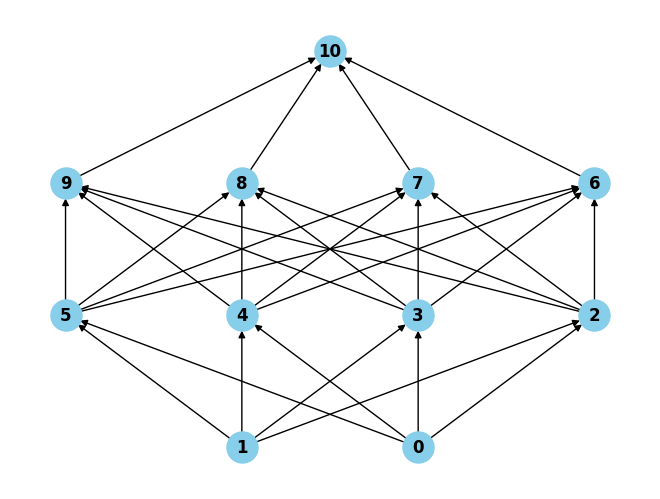

In [2]:
TR_INPUT = 2
TR_OUTPUT = 1
topology = create_stratified_topology([TR_INPUT, 4, 4, TR_OUTPUT], [[None, []]]*TR_INPUT + [['sigmoid', [1]]]*4 + [['sigmoid', [1]]]*4 + [['identity', []]]*TR_OUTPUT)
NeuralNetwork.display_topology(topology)

In [3]:
topology

{0: ['input_0', None, [], [2, 3, 4, 5]],
 1: ['input_0', None, [], [2, 3, 4, 5]],
 2: ['hidden_1', 'sigmoid', [1], [6, 7, 8, 9]],
 3: ['hidden_1', 'sigmoid', [1], [6, 7, 8, 9]],
 4: ['hidden_1', 'sigmoid', [1], [6, 7, 8, 9]],
 5: ['hidden_1', 'sigmoid', [1], [6, 7, 8, 9]],
 6: ['hidden_2', 'sigmoid', [1], [10]],
 7: ['hidden_2', 'sigmoid', [1], [10]],
 8: ['hidden_2', 'sigmoid', [1], [10]],
 9: ['hidden_2', 'sigmoid', [1], [10]],
 10: ['output_3', 'identity', [], []]}

In [4]:
len_dataset = 1200
len_training = 1000
len_validation = 200
dummy = create_dataset(len_dataset, TR_INPUT, [-10, 10], 
                      [#lambda x : 2*x[0]**3 - 20*x[1]**2 + 2, # solo primi 2 input
                       lambda x : x[1]**2 + x[1]*5 + x[0]**2 + x[0]*5 if (x[0] > 0 and x[1] > 0) or (x[0] < 0 and x[1] < 0) else -x[1]**2 -x[1]*5 - x[0]**2 -x[0]*5
                       ], 
                      RANDOM_STATE)
tr_df = dummy[:len_training]
val_df = dummy[-len_validation:]
tr_df.sample(10, random_state=RANDOM_STATE)

,input_1,input_2,output_1
114,2.464804,7.664989,115.476278
91,-0.398958,1.421985,-7.296347
67,-6.285247,2.323199,-25.091344
953,-8.094781,6.110915,-92.949432
711,-8.880031,0.408972,-36.666909
727,-8.908266,-5.653696,38.511673
839,6.310457,8.356269,182.982720
789,1.446441,-7.272174,-25.848042
670,0.176441,5.900252,65.227576
47,-8.539224,4.884860,-78.508395


In [5]:
scaler_out = StandardScaler()
scaler_in = StandardScaler()
scaler_in.fit(tr_df.values[:,:TR_INPUT])
scaler_out.fit(tr_df.values[:,TR_INPUT:])

tr_normalized = np.empty((len_training, TR_OUTPUT + TR_INPUT))
tr_normalized[:,:TR_INPUT] = scaler_in.transform(tr_df.values[:,:TR_INPUT])
tr_normalized[:,TR_INPUT:] = scaler_out.transform(tr_df.values[:,TR_INPUT:])

val_normalized = np.empty((len_validation, TR_OUTPUT + TR_INPUT))
val_normalized[:,:TR_INPUT] = scaler_in.transform(val_df.values[:,:TR_INPUT])
val_normalized[:,TR_INPUT:] = scaler_out.transform(val_df.values[:,TR_INPUT:])

In [6]:
tr_df_normalized = pd.DataFrame(data = tr_normalized, columns=tr_df.columns)
val_df_normalized = pd.DataFrame(data = val_normalized, columns=tr_df.columns)

In [7]:
training_set = tr_df.values
validation_set = val_df.values
metrics = [ErrorFunctions.mean_squared_error, ] #ErrorFunctions.mean_euclidean_error, 

batch_size = 50
max_epochs = 4096

error_decrease_tolerance = 0.000001
patience = 16
min_epochs = 128

lambda_tikhonov = 0
alpha_momentum = 0.0
learning_rate = 0.05/batch_size

collect_datas = True
collect_datas_batch = False # per il momento. molto costoso!!!! False di default
verbose = True

NN = NeuralNetwork(topology, -0.75, 0.75, True, RANDOM_STATE)
stats = NN.train(tr_normalized, val_normalized, batch_size, max_epochs, error_decrease_tolerance, patience, min_epochs, 
                   learning_rate, lambda_tikhonov, alpha_momentum, metrics, collect_datas, collect_datas_batch, verbose)

starting values:  {'training_set_len': 1000, 'minibatch_size': 50, 'max_epochs': 4096, 'error_decrease_tolerance': 1e-06, 'patience': 16, 'min_epochs': 128, 'learning_rate': 0.001, 'lambda_tikhonov': 0, 'alpha_momentum': 0.0, 'epochs': 0, 'total_train_time': datetime.timedelta(0), 'mean_epoch_train_time': 0, 'units_weights': {5: [], 4: [], 3: [], 2: [], 9: [], 8: [], 7: [], 6: [], 10: []}, 'units_weights_batch': {5: [], 4: [], 3: [], 2: [], 9: [], 8: [], 7: [], 6: [], 10: []}, 'training_mean_squared_error': [], 'validation_mean_squared_error': [], 'training_batch_mean_squared_error': [], 'validation_batch_mean_squared_error': []}
[1/4096] tr time: 0:00:00.414997 | mean_squared_error: tr=1.0096373733332553 val=0.8498913294916554 | 
[2/4096] tr time: 0:00:00.400967 | mean_squared_error: tr=1.0033632185547294 val=0.8420218376503373 | 
[3/4096] tr time: 0:00:00.405533 | mean_squared_error: tr=0.9991060271685043 val=0.8388224574566868 | 
[4/4096] tr time: 0:00:00.414064 | mean_squared_error

In [8]:
tr_predictions_normalized = NN.predict_array(tr_normalized[:,:TR_INPUT])
tr_predictions = scaler_out.inverse_transform(tr_predictions_normalized)

In [9]:
pd.options.mode.chained_assignment = None
pred_cols = ['prediction_' + str(i + 1) for i in range(TR_OUTPUT)]
tr_df[pred_cols] = tr_predictions
for col in pred_cols:
    tr_df[col + '_err'] = (tr_df[col] - tr_df['output_' + col[-1]])**2


tr_df_normalized[pred_cols] = tr_predictions_normalized
for col in pred_cols:
    tr_df_normalized[col + '_err'] = (tr_df_normalized[col] - tr_df_normalized['output_' + col[-1]])**2

In [10]:
tr_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,output_1,prediction_1,prediction_1_err
114,2.464804,7.664989,115.476278,36.284420,6271.350444
91,-0.398958,1.421985,-7.296347,-18.428265,123.919601
67,-6.285247,2.323199,-25.091344,-23.175438,3.670698
953,-8.094781,6.110915,-92.949432,-23.175509,4868.400428
711,-8.880031,0.408972,-36.666909,-23.175517,182.017662


In [11]:
val_predictions_normalized = NN.predict_array(val_normalized[:,:TR_INPUT])
val_predictions = scaler_out.inverse_transform(val_predictions_normalized)

In [12]:
val_df[pred_cols] = val_predictions
for col in pred_cols:
    val_df[col + '_err'] = (val_df[col] - val_df['output_' + col[-1]])**2


val_df_normalized[pred_cols] = val_predictions_normalized
for col in pred_cols:
    val_df_normalized[col + '_err'] = (val_df_normalized[col] - val_df_normalized['output_' + col[-1]])**2

In [13]:
val_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,output_1,prediction_1,prediction_1_err
1054,4.407299,0.511956,44.282662,36.416319,61.879355
1143,-2.985410,9.325098,-127.568564,-23.104706,10912.697561
1016,8.810155,2.899749,144.576903,36.435203,11694.627188
1102,-0.397214,2.909409,-21.183419,-15.841493,28.536174
1117,8.671196,-8.910700,-153.392696,36.435099,36034.591966


In [14]:
for key in list(stats.keys())[:12]:
    print(key, ':', stats[key])

training_set_len : 1000
minibatch_size : 50
max_epochs : 4096
error_decrease_tolerance : 1e-06
patience : 16
min_epochs : 128
learning_rate : 0.001
lambda_tikhonov : 0
alpha_momentum : 0.0
epochs : 598
total_train_time : 0:03:59.825500
mean_epoch_train_time : 0:00:00.401046


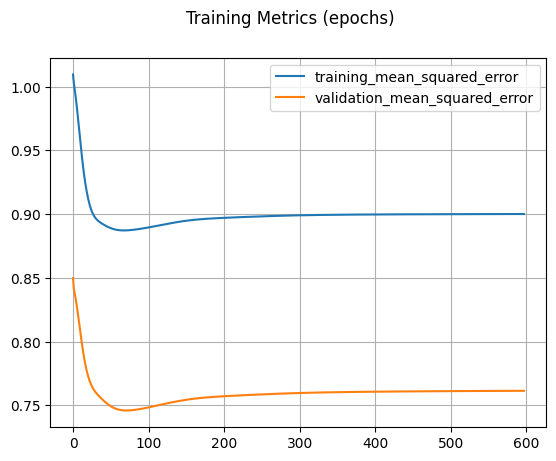

In [15]:
if len(metrics) > 1:
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Training Metrics (epochs)')
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['validation_' + metrics[i].__name__]], 
                ['training_' + metrics[i].__name__, 'validation_' + metrics[i].__name__],
                ax=ax[i])
else:
    plt.suptitle('Training Metrics (epochs)')
    multy_plot([stats['training_' + metrics[0].__name__], stats['validation_' + metrics[0].__name__]], 
                ['training_' + metrics[0].__name__, 'validation_' + metrics[0].__name__])

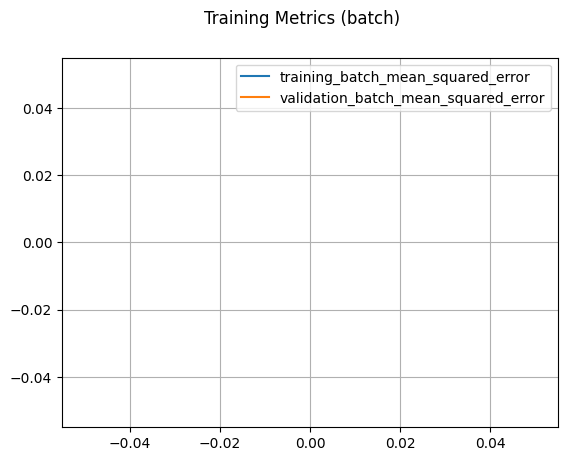

In [16]:
if len(metrics) > 1:
    fig, ax = plt.subplots(1, len(metrics), figsize=(10, 5))
    plt.suptitle('Learning Curve (batch)')
    for i in range(len(metrics)):
        multy_plot([stats['training_batch_' + metrics[i].__name__], stats['validation_batch_' + metrics[i].__name__]], 
                ['training_batch_' + metrics[i].__name__, 'validation_batch_' + metrics[i].__name__],
                ax=ax[i])
    plt.show()
else:
    plt.suptitle('Training Metrics (batch)')
    multy_plot([stats['training_batch_' + metrics[0].__name__], stats['validation_batch_' + metrics[0].__name__]], 
                ['training_batch_' + metrics[0].__name__, 'validation_batch_' + metrics[0].__name__])

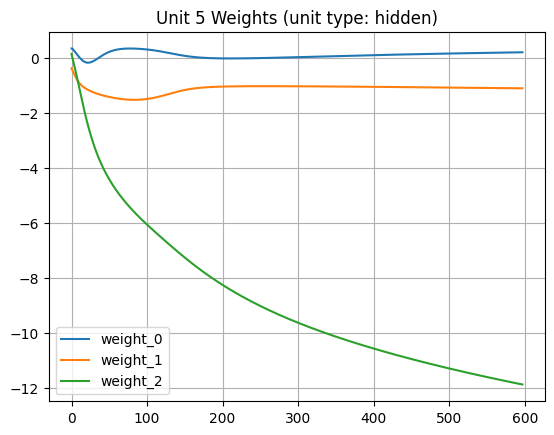

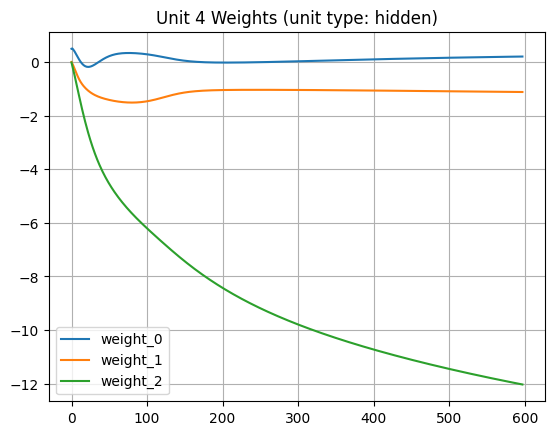

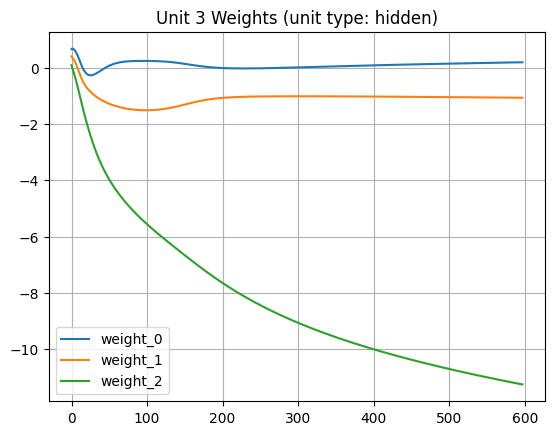

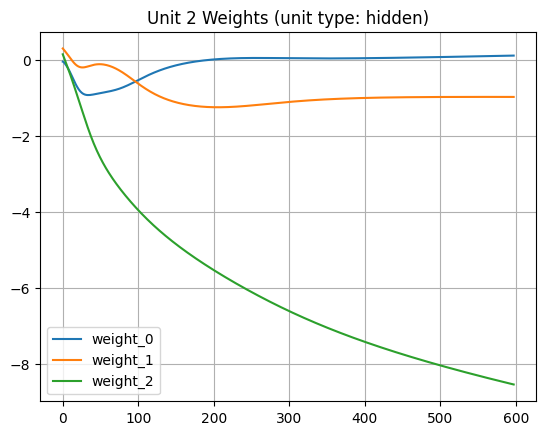

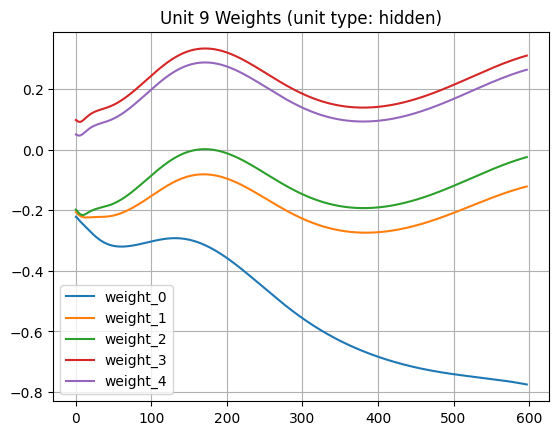

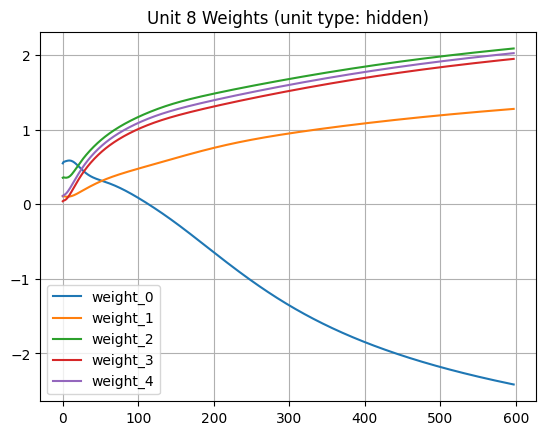

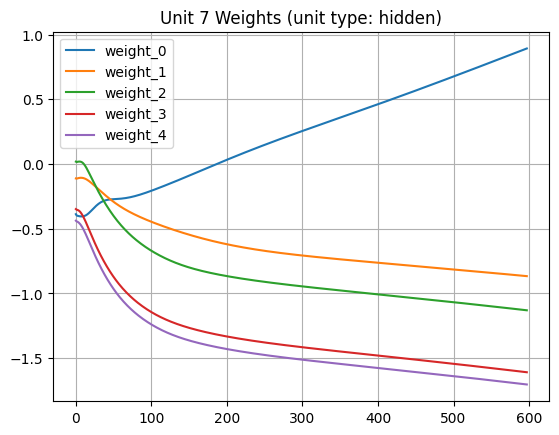

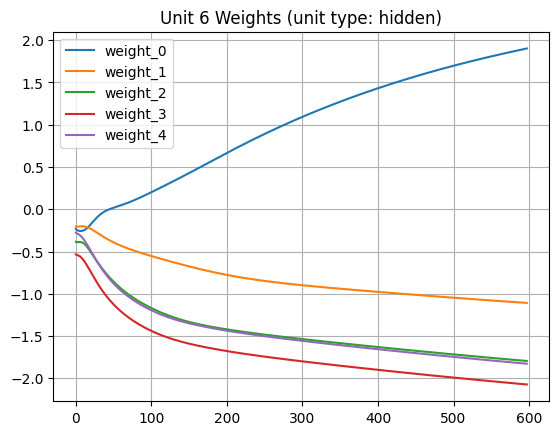

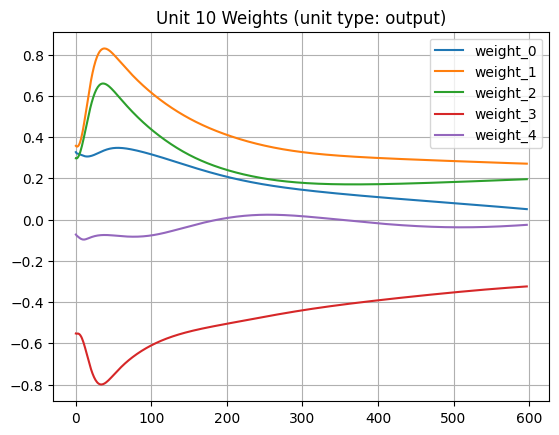

In [17]:
for unit_index in stats['units_weights'].keys():
    vals = np.array(stats['units_weights'][unit_index]).T
    multy_plot(vals, 
               ['weight_' + str(i) for i in range(len(vals))], 
               'Unit ' + str(unit_index) + ' Weights (unit type: ' + NN.neurons[unit_index].type + ')')

In [18]:
tr_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,output_1,prediction_1,prediction_1_err
114,2.464804,7.664989,115.476278,36.284420,6271.350444
91,-0.398958,1.421985,-7.296347,-18.428265,123.919601
67,-6.285247,2.323199,-25.091344,-23.175438,3.670698
953,-8.094781,6.110915,-92.949432,-23.175509,4868.400428
711,-8.880031,0.408972,-36.666909,-23.175517,182.017662


In [19]:
val_df.sample(5, random_state=RANDOM_STATE)

,input_1,input_2,output_1,prediction_1,prediction_1_err
1054,4.407299,0.511956,44.282662,36.416319,61.879355
1143,-2.985410,9.325098,-127.568564,-23.104706,10912.697561
1016,8.810155,2.899749,144.576903,36.435203,11694.627188
1102,-0.397214,2.909409,-21.183419,-15.841493,28.536174
1117,8.671196,-8.910700,-153.392696,36.435099,36034.591966


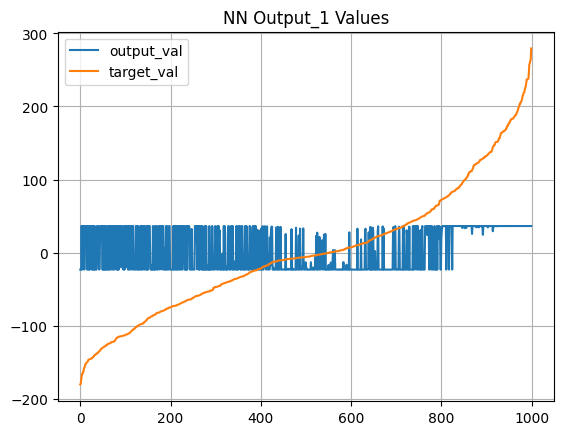

In [20]:
for i in range(TR_OUTPUT):
    sorted_order = training_set[:, TR_INPUT + i].argsort()
    multy_plot([tr_predictions[sorted_order][:,i] , training_set[sorted_order][:,TR_INPUT + i]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')

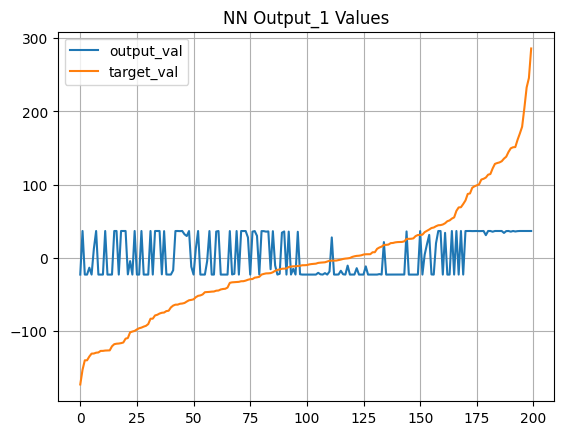

In [21]:
for i in range(TR_OUTPUT):
    sorted_order = validation_set[:, TR_INPUT + i].argsort()
    multy_plot([val_predictions[sorted_order][:,i] , validation_set[sorted_order][:,TR_INPUT + i]], 
                ['output_val', 'target_val'], 
                'NN Output_' + str(i + 1) +  ' Values')

Tot points: 1000


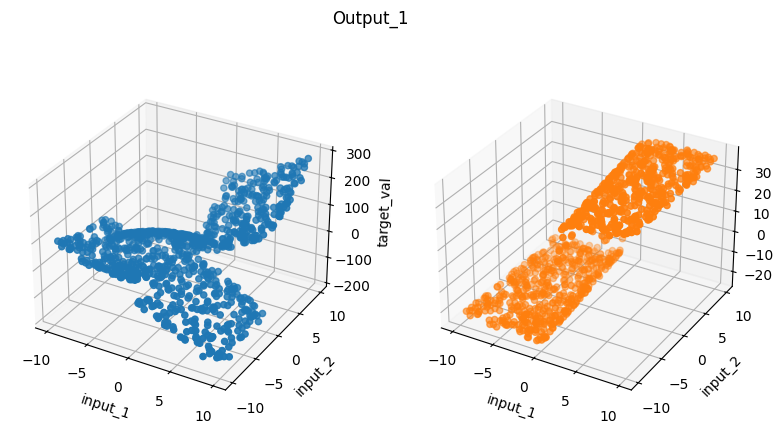

In [30]:
for i in range(1, TR_OUTPUT + 1):
    multy_plot_3d([tr_df['input_1'].values, tr_df['input_1'].values], 
              [tr_df['input_2'].values, tr_df['input_2'].values],
              [tr_df['output_' + str(i)].values, tr_df['prediction_' + str(i)].values],
              [['input_1', 'input_2', 'target_val'], ['input_1', 'input_2', 'output_val']],
              'Output_' + str(i));


In [32]:
for i in range(1, TR_OUTPUT + 1):
    interactive_3d_plot(tr_df_normalized, 'input_1', 'input_2', 'prediction_' + str(i), 'prediction_' +str(i) + '_err').show()
    interactive_3d_plot(tr_df_normalized, 'input_1', 'input_2', 'output_' + str(i), 'prediction_' +str(i) + '_err').show()

Tot points: 1000


Tot points: 1000


In [34]:
for i, neuron in enumerate(reversed(NN.neurons[-NN.output_size:])):
    print('index unit:',neuron.index, '| act fun:' ,neuron.f.__name__, '| corresp output:', tr_df.columns[-(i+1) - 1])

index unit: 10 | act fun: identity | corresp output: prediction_1


In [38]:
for neuron in NN.neurons[NN.input_size:]:
    print('index unit:', neuron.index, '| act fun:' ,neuron.f.__name__)

index unit: 5 | act fun: sigmoid
index unit: 4 | act fun: sigmoid
index unit: 3 | act fun: sigmoid
index unit: 2 | act fun: sigmoid
index unit: 9 | act fun: sigmoid
index unit: 8 | act fun: sigmoid
index unit: 7 | act fun: sigmoid
index unit: 6 | act fun: sigmoid
index unit: 10 | act fun: identity
